 This part is trying to build an A2C model for trading.

In [1]:
import matplotlib.pyplot as plt
import os
import gym
import numpy as np
import tensorflow as tf
import tensorlayer as tl

In [2]:
import gym

import preprocessing_stockenv
import preprocessing_adding_technical_indicator

import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as kl

In [3]:
# actor nn
class Actor(object):

    def __init__(self, state_dim =8, action_dim =3, lr=0.001):
        

        input_layer = tl.layers.Input([None, state_dim])
        layer = tl.layers.Dense(n_units=16, act=tf.nn.relu6)(input_layer)
        layer = tl.layers.Dense(n_units=action_dim)(layer)
#         input_layer =kl.Input(shape=state_dim)
#         layer1 = kl.Dense(12,activation ='elu')(input_layer)
#         layer2 = kl.Dense(3)(layer1)

        self.model = tl.models.Model(inputs=input_layer, outputs=layer)  # define the model in and out
#         self.model = keras.Model(inputs = [input_layer],outputs =[layer2])
        self.model.train()
        self.optimizer = tf.optimizers.Adam(lr)

    def learn(self, state, action, td_error):  # update weights according to cross_entropy
        with tf.GradientTape() as tape:
            _logits = self.model(np.array([state]))
            _exp_v = tl.rein.cross_entropy_reward_loss(
                logits=_logits, actions=[action], rewards=td_error)
        grad = tape.gradient(_exp_v, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_weights))

    def get_action(self, state,epsilon = 0.2):  # option : greedy para to get the max prob
        if np.random.rand() < epsilon:
            return np.random.randint(3)
        else:
            _logits = self.model(np.array([state]))
            _prob = tf.nn.softmax(_logits).numpy()
            return tl.rein.choice_action_by_probs(_prob.ravel())


In [4]:
# critic nn
class Critic(object):

    def __init__(self, state_dim =9, lr=0.01): # 8 or 9 should be more than  actor because need to input action
        input_layer = tl.layers.Input([None, state_dim])
        layer = tl.layers.Dense(n_units=18, act=tf.nn.relu)(input_layer) # 12  is the twice of the input dimension
        layer = tl.layers.Dense(n_units=1, act=None)(layer)  # output one

        self.model = tl.models.Model(inputs=input_layer, outputs=layer)
        self.model.train()
        self.optimizer = tf.optimizers.Adam(lr)

    def learn(self, state, reward, state_, done, action, action_):
        d = 0 if done else 1
        input1 = np.append(state,action).astype(np.float32)
        input2 = np.append(state_,action_).astype(np.float32)

        with tf.GradientTape() as tape:
            v = self.model(np.array([input1]))
            v_ = self.model(np.array([input2])) # new state  value
            td_error = reward + d * gamma * v_ - v
            loss = tf.square(td_error)  # MSE
        grads = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return td_error


In [5]:
data = preprocessing_adding_technical_indicator.add_technical_indicator()
env = preprocessing_stockenv.StockEnv(data)
LR_A = 0.001  # learning rate for actor
LR_C = 0.01  # learning rate for critic
decay = 0.005 # learning rate decay
gamma = 0.95 # discount factor

[1.00000e+03 0.00000e+00 0.00000e+00 2.53000e+02 0.00000e+00 6.66667e+01
 3.72549e+01 3.24421e+05]


In [9]:
len(data)

4182

In [6]:
actor = Actor(8, env.action_space.n, lr=LR_A)
critic = Critic(9, lr=LR_C)

[TL] Input  _inputlayer_1: [None, 8]
[TL] Dense  dense_1: 16 relu6
[TL] Dense  dense_2: 3 No Activation
[TL] Input  _inputlayer_2: [None, 9]
[TL] Dense  dense_3: 18 relu
[TL] Dense  dense_4: 1 No Activation


In [7]:
# def trade_time_unit(env, obs):  #  using greedy policy
#     action = actor.get_action(obs) # get the action
#     print(action)
#     next_state, reward, done, info = env.step(action)
#     return next_state, reward, done, info

In [10]:
def train_one_episode():
    env.reset()
    state = env.reset().astype(np.float32)
    reward_total = 0
    for step in range(4500):
        action = actor.get_action(state)
        next_state, reward, done, info = env.step(action)
        reward_total = reward_total + reward
        next_state = next_state.astype(np.float32)
        action_ = actor.get_action(next_state)
        td_error = critic.learn(state,reward,next_state,done,action, action_)
        actor.learn(state,action,td_error)
        state = next_state
        if done:
            print(state)
            break
    print("For this episode,reward total:{}".format(reward_total))

In [11]:
for i in range(400):
    train_one_episode()

[ 5.42752e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-457.24800000000005
[ 1.30680e+03  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:306.79999999999995
[ 0.00000e+00  2.35000e+02  4.48800e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:9.800000000000068
[ 6.21900e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-378.0999999999999
[ 0.00000e+00  2.25000e+02  2.09300e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-528.9699999999967
[ 5.31450e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-468.5499999999997
[ 0.00000e+00  2.29000e+02  5.17800e+00  2.25000e+02 -4.21900e-0

[ 6.84481e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-315.519
[ 0.00000e+00  2.33000e+02  2.72300e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-387.3250000000001
[ 7.60928e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-239.072
[ 0.00000e+00  2.26000e+02  4.24300e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-45.32499999999993
[ 1.12860e+03  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:128.5999999999999
[ 1.983369e+03  0.000000e+00  0.000000e+00  2.250000e+02 -4.219000e-01
 -3.942650e+01  4.368340e+01  3.029420e+05]
For this episode,reward total:983.3689999999999
[ 8.75104e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+0

[ 3.95483e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-604.517
[ 1.621858e+03  0.000000e+00  0.000000e+00  2.250000e+02 -4.219000e-01
 -3.942650e+01  4.368340e+01  3.029420e+05]
For this episode,reward total:621.858
[ 0.00000e+00  2.30000e+02  4.17300e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-61.075000000000045
[ 0.00000e+00  2.29000e+02  2.23000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-498.25000000000034
[ 0.00000e+00  2.29000e+02  2.92500e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-341.875
[ 5.85800e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-414.20000000000005
[ 0.00000e+00  2.38000e+02  5.57000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.3

[ 0.00000e+00  2.30000e+02  2.61600e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-411.4000000000002
[ 0.00000e+00  2.28000e+02  5.00100e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:125.22500000000014
[ 0.00000e+00  2.30000e+02  2.29100e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-484.5250000000002
[ 0.00000e+00  2.33000e+02  6.12400e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:377.89999999999986
[ 0.00000e+00  2.24000e+02  4.46400e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:4.400000000000091
[ 0.00000e+00  2.31000e+02  5.20500e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:171.125
[ 0.00000e+00  2.26000e+02  3.23100e+00  2.25000e+02 -4.21900e-01
 -3.94265e

[ 0.00000e+00  2.26000e+02  2.98600e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-328.15000000000003
[ 0.00000e+00  2.29000e+02  4.11700e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-73.67499999999995
[ 1.46790e+03  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:467.9000000000001
[ 0.00000e+00  2.17000e+02  3.82000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-140.5
[ 0.00000e+00  2.17000e+02  4.39500e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-11.125000000000114
[ 0.00000e+00  2.25000e+02  1.54700e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-651.9460000000001
[ 0.00000e+00  2.35000e+02  3.48700e+00  2.25000e+02 -4.21900e-01
 -3.94265

[ 0.00000e+00  2.28000e+02  3.15800e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-289.45000000000005
[ 0.00000e+00  2.28000e+02  4.01300e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-97.07500000000005
[ 1.509348e+03  0.000000e+00  0.000000e+00  2.250000e+02 -4.219000e-01
 -3.942650e+01  4.368340e+01  3.029420e+05]
For this episode,reward total:509.34799999999996
[ 0.00000e+00  2.24000e+02  3.78100e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-149.27499999999998
[ 1.20600e+03  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:206.0
[ 0.00000e+00  2.31000e+02  6.50600e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:463.85000000000014
[ 0.00000e+00  2.30000e+02  8.55100e+00  2.25000e+02 -4.21900e-01
 

[ 0.00000e+00  2.32000e+02  3.49300e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-214.07500000000005
[ 9.12375e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-87.62499999999989
[ 0.00000e+00  2.29000e+02  2.35200e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-470.80000000000024
[ 0.00000e+00  2.24000e+02  5.28000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:188.0
[ 9.19980e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-80.01999999999998
[ 2.18201e+03  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:1182.0100000000002
[ 0.00000e+00  2.17000e+02  3.82800e+00  2.25000e+02 -4.21900e-01
 -3.94265

[ 0.00000e+00  2.30000e+02  3.46900e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-219.47500000000002
[ 0.00000e+00  2.33000e+02  4.94200e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:111.95000000000005
[ 1.083264e+03  0.000000e+00  0.000000e+00  2.250000e+02 -4.219000e-01
 -3.942650e+01  4.368340e+01  3.029420e+05]
For this episode,reward total:83.2639999999999
[ 7.23520e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-276.48
[ 5.39385e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-460.6149999999997
[ 0.00000e+00  2.25000e+02  3.69200e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-169.3599999999999
[ 0.00000e+00  2.17000e+02  3.21400e+00  2.25000e+02 -4.21900e-01
 -

After running more than 400 episodes, it seems hard to converge.

In [12]:
l =env.money_memory

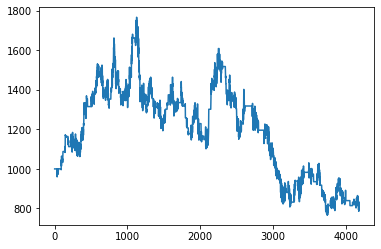

In [13]:
%matplotlib inline
plt.plot(l)
plt.show()

[ 0.00000e+00  2.24000e+02  5.51200e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:240.19999999999982
[ 0.00000e+00  2.30000e+02  2.49500e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-438.6249999999989
[ 0.00000e+00  2.28000e+02  6.12900e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:379.02499999999986
[ 6.40284e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-359.716
[ 9.87133e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-12.866999999999962
[ 0.00000e+00  2.39000e+02  4.15500e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-65.125
[ 0.00000e+00  2.32000e+02  4.80300e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.3

[ 4.47678e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-552.3220000000002
[ 0.00000e+00  2.33000e+02  7.31800e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:646.55
[ 0.00000e+00  2.17000e+02  4.11600e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-73.90000000000009
[ 6.15600e+02  0.00000e+00  0.00000e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:-384.4
[ 2.263072e+03  0.000000e+00  0.000000e+00  2.250000e+02 -4.219000e-01
 -3.942650e+01  4.368340e+01  3.029420e+05]
For this episode,reward total:1263.0720000000001
[ 0.00000e+00  2.27000e+02  5.63400e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  4.36834e+01  3.02942e+05]
For this episode,reward total:267.6500000000001
[ 0.00000e+00  2.25000e+02  8.62600e+00  2.25000e+02 -4.21900e-01
 -3.94265e+01  

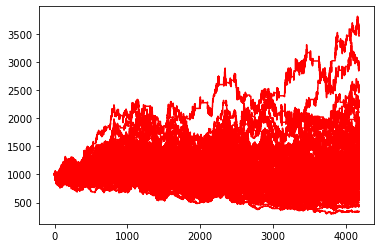

In [14]:
for i in range(100):
    train_one_episode()

In [15]:
l =env.money_memory

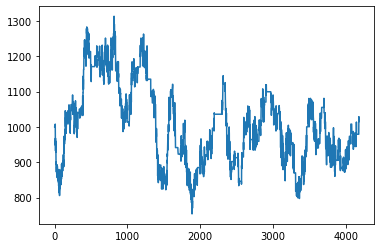

Text(0, 0.5, 'total money')

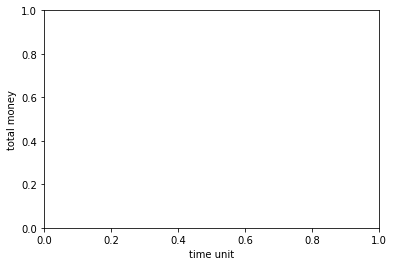

In [17]:
%matplotlib inline
plt.plot(l)
plt.show()
plt.xlabel("time unit")
plt.ylabel("total money")